# Week 8 — Final Sentiment Analysis Model (Binary)

**Thesis Context**: This notebook reproduces and improves the end‑to‑end experiment for sentiment analysis of Amazon reviews, with a specific focus on **time‑of‑day and negativity**.

**Research Questions**:
- **RQ1**: Does time‑of‑day relate to negativity patterns in reviews?
- **RQ2**: Do engineered time‑based features improve sentiment prediction beyond text‑only models?

**Classification (Binary)**:
- Negative (0): rating ≤ 2
- Positive (1): rating ≥ 3

**Seed Requirement**:
This notebook runs the full pipeline **twice**:
- Run A: seed = 319302
- Run B: random 6‑digit seed generated at runtime

**Note**: This notebook **does not use Unsloth**.


## Colab Setup (optional Google Drive)
If you want to store outputs in Google Drive, uncomment and run the cell below, then set `USE_DRIVE = True` in the configuration cell.

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')


In [6]:
# === 1) Install + Imports (single cell) ===
import os
import sys
import json
import subprocess

# Disable W&B by default
os.environ["WANDB_DISABLED"] = "true"

# Install required packages (single clean cell)
packages = [
    "pandas>=2.0.0",
    "numpy>=1.24.0",
    "matplotlib>=3.7.0",
    "seaborn>=0.12.0",
    "scikit-learn>=1.3.0",
    "transformers>=4.40.0",
    "datasets>=2.18.0",
    "evaluate>=0.4.1",
    "accelerate>=0.20.0",
    "pyarrow>=10.0.0",
]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datetime import datetime
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# GPU check
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  No GPU detected. Transformer will run in FAST_RUN mode.")


✓ GPU available: NVIDIA A100-SXM4-80GB


In [7]:
# === 2) Configuration ===
DATA_PATH = "/content/Amazon_Data.csv"  # set your path
FILE_TYPE = "auto"  # "csv", "parquet", "jsonl", or "auto"
TEXT_COL = None     # set if your column names differ
RATING_COL = None   # set if your column names differ
TIME_COL = None     # set if your column names differ

STUDENT_SEED = 319302
FAST_RUN = True
SAMPLE_FOR_TEXT = 100000  # for heavy text models; set None to use full train

MAX_SEQ_LEN_BERT = 256
BERT_EPOCHS = 1 if FAST_RUN else 3
BERT_BATCH = 16

USE_DRIVE = False
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/GRAD699/Week8/"

# Output folders
OUTPUT_DIR = DRIVE_OUTPUT_DIR if USE_DRIVE else "outputs"
FIGURES_DIR = os.path.join(OUTPUT_DIR, "figures")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")
TABLES_DIR = os.path.join(OUTPUT_DIR, "tables")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

label_map = {0: "Negative", 1: "Positive"}

print("✓ Config loaded")


✓ Config loaded


## Utilities

In [8]:
def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def parse_timestamp(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        max_val = series.max()
        if max_val > 1e12:
            return pd.to_datetime(series, errors="coerce", unit="ms")
        if max_val > 1e9:
            return pd.to_datetime(series, errors="coerce", unit="s")
    return pd.to_datetime(series, errors="coerce")

def daypart_from_hour(hour: int) -> str:
    if 0 <= hour <= 4:
        return "late_night"
    if 5 <= hour <= 11:
        return "morning"
    if 12 <= hour <= 16:
        return "afternoon"
    if 17 <= hour <= 20:
        return "evening"
    return "night"

def load_data(path: str, file_type: str) -> pd.DataFrame:
    ftype = file_type.lower() if isinstance(file_type, str) else "auto"
    if ftype == "auto":
        if path.endswith(".parquet"):
            ftype = "parquet"
        elif path.endswith(".jsonl"):
            ftype = "jsonl"
        else:
            ftype = "csv"

    if ftype == "csv":
        return pd.read_csv(path)
    if ftype == "parquet":
        return pd.read_parquet(path)
    if ftype == "jsonl":
        return pd.read_json(path, lines=True)
    raise ValueError("FILE_TYPE must be one of: csv, parquet, jsonl, auto")

def find_column(df, candidates, override=None):
    if override:
        if override in df.columns:
            return override
        raise ValueError(f"Column '{override}' not found in dataset.")
    for c in candidates:
        if c in df.columns:
            return c
    return None

def chronological_split(df, train_ratio=0.8, val_ratio=0.1):
    n = len(df)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    train = df.iloc[:n_train].copy()
    val = df.iloc[n_train:n_train + n_val].copy()
    test = df.iloc[n_train + n_val:].copy()
    return train, val, test

def eval_binary_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
        except Exception:
            metrics["roc_auc"] = float("nan")
    else:
        metrics["roc_auc"] = float("nan")
    return metrics

def build_time_features(df):
    df = df.copy()
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["daypart"] = df["hour"].apply(daypart_from_hour)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    return df

def build_time_matrix(train_df, val_df, test_df):
    num_features = ["hour_sin", "hour_cos", "is_weekend"]
    cat_features = ["day_of_week", "daypart"]
    enc = OneHotEncoder(handle_unknown="ignore", sparse=True)
    enc.fit(train_df[cat_features])
    train_cat = enc.transform(train_df[cat_features])
    val_cat = enc.transform(val_df[cat_features])
    test_cat = enc.transform(test_df[cat_features])
    train_num = csr_matrix(train_df[num_features].values)
    val_num = csr_matrix(val_df[num_features].values)
    test_num = csr_matrix(test_df[num_features].values)
    return (hstack([train_num, train_cat]),
            hstack([val_num, val_cat]),
            hstack([test_num, test_cat]))


## 3) Load data (raw showcase)

Shape: (701528, 10)
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Dtypes:
rating                int64
title                object
text                 object
images               object
asin                 object
parent_asin          object
user_id              object
timestamp            object
helpful_vote          int64
verified_purchase      bool
dtype: object

Sample rows:


,timestamp,rating,text
0,2020-05-05 14:08:48.923,5,This spray is really nice. It smells really go...
1,2020-05-04 18:10:55.070,4,"This product does what I need it to do, I just..."
2,2020-05-16 21:41:06.052,5,"Smells good, feels great!"
3,2022-01-28 18:13:50.220,1,Felt synthetic
4,2020-12-30 10:02:43.534,5,Love it
5,2020-08-27 22:30:08.138,4,The polish was quiet thick and did not apply s...
6,2021-09-17 13:31:59.443,5,Great for many tasks. I purchased these for m...
7,2021-10-15 05:20:59.292,3,These were lightweight and soft but much too s...
8,2021-07-27 13:04:04.559,5,This is perfect for my between salon visits. I...
9,2021-07-18 13:21:51.145,5,I get Keratin treatments at the salon at least...



Missingness summary:
text         212
rating         0
timestamp      0
dtype: int64


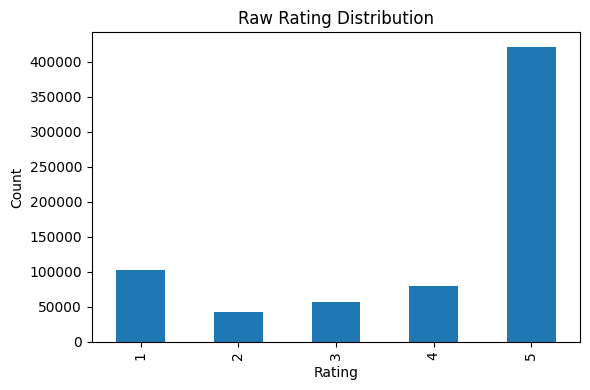

In [9]:
df_raw = load_data(DATA_PATH, FILE_TYPE)

text_col = find_column(df_raw, ["text", "review", "reviewText"], TEXT_COL)
rating_col = find_column(df_raw, ["rating", "stars", "overall"], RATING_COL)
time_col = find_column(df_raw, ["timestamp", "reviewTime", "time"], TIME_COL)

if text_col is None or rating_col is None or time_col is None:
    raise ValueError("Missing required columns. Please set TEXT_COL, RATING_COL, TIME_COL.")

df_raw = df_raw.rename(columns={text_col: "text", rating_col: "rating", time_col: "timestamp"})

print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
print("Dtypes:")
print(df_raw.dtypes)

print("\nSample rows:")
display(df_raw[["timestamp", "rating", "text"]].head(20))

print("\nMissingness summary:")
print(df_raw[["text", "rating", "timestamp"]].isna().sum())

plt.figure(figsize=(6, 4))
df_raw["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Raw Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "raw_rating_distribution.png"), dpi=150)
plt.show()


## 4) Clean + preprocess + label

In [10]:
df = df_raw.dropna(subset=["text", "rating", "timestamp"]).copy()
df["timestamp"] = parse_timestamp(df["timestamp"])
df = df.dropna(subset=["timestamp"]).copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].copy()

# Binary label mapping
df["label"] = df["rating"].apply(lambda r: 0 if r <= 2 else 1)
df["label_name"] = df["label"].map(label_map)

# Basic text features
df["review_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

# Sort chronologically
df = df.sort_values("timestamp").reset_index(drop=True)

print("Cleaned shape:", df.shape)
print(df[["label_name"]].value_counts())


Cleaned shape: (700703, 14)
label_name
Positive      555751
Negative      144952
Name: count, dtype: int64


## 5) Feature engineering (time-of-day)

In [11]:
df = build_time_features(df)
print("✓ Time features created")


✓ Time features created


## 6) Chronological split (train/val/test)

In [12]:
df_train, df_val, df_test = chronological_split(df, train_ratio=0.8, val_ratio=0.1)

print("Train range:", df_train["timestamp"].min(), "to", df_train["timestamp"].max())
print("Val range:", df_val["timestamp"].min(), "to", df_val["timestamp"].max())
print("Test range:", df_test["timestamp"].min(), "to", df_test["timestamp"].max())

assert df_train["timestamp"].max() <= df_val["timestamp"].min(), "Train/Val overlap"
assert df_val["timestamp"].max() <= df_test["timestamp"].min(), "Val/Test overlap"

print("Sizes:", len(df_train), len(df_val), len(df_test))
print("Train label distribution:\n", df_train["label_name"].value_counts())
print("Val label distribution:\n", df_val["label_name"].value_counts())
print("Test label distribution:\n", df_test["label_name"].value_counts())


Train range: 2000-11-01 04:24:18 to 2021-05-23 03:30:10.468000
Val range: 2021-05-23 03:35:58.201000 to 2022-01-25 01:25:38.643000
Test range: 2022-01-25 01:31:03.492000 to 2023-09-09 00:39:36.666000
Sizes: 560562 70070 70071
Train label distribution:
 label_name
Positive    453085
Negative    107477
Name: count, dtype: int64
Val label distribution:
 label_name
Positive    50209
Negative    19861
Name: count, dtype: int64
Test label distribution:
 label_name
Positive    52457
Negative    17614
Name: count, dtype: int64


## 7) RQ1 Visualizations (negativity vs time)

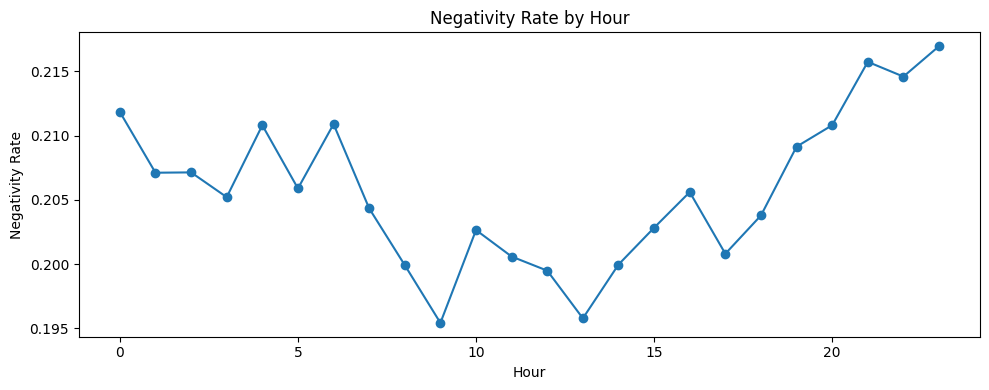

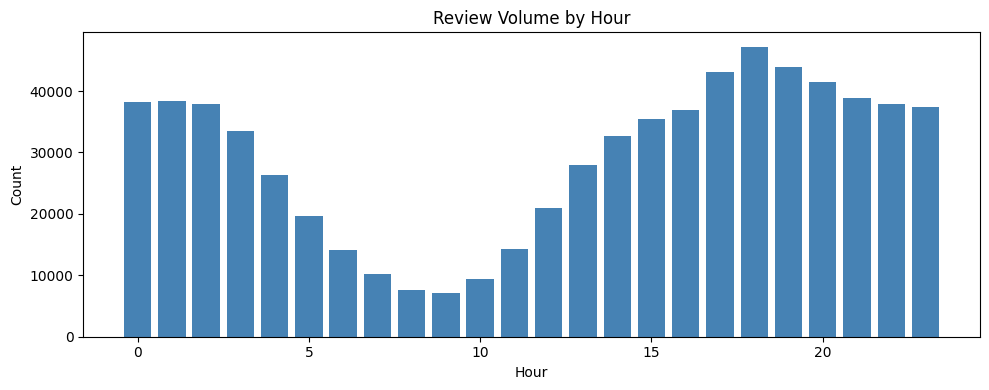

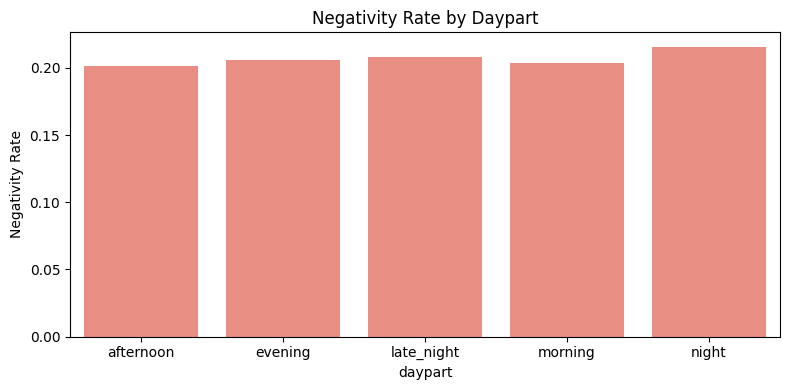

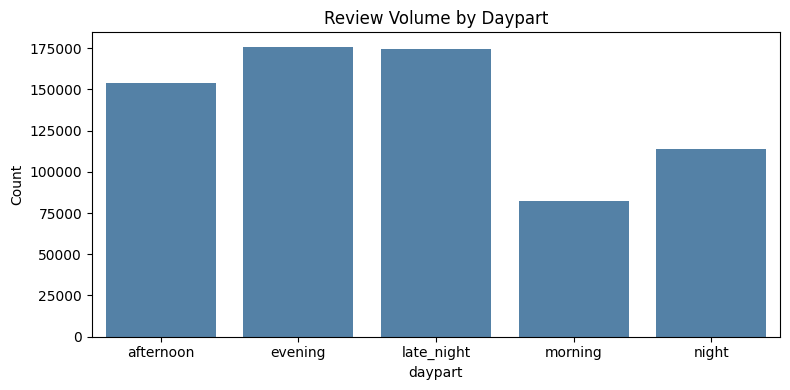

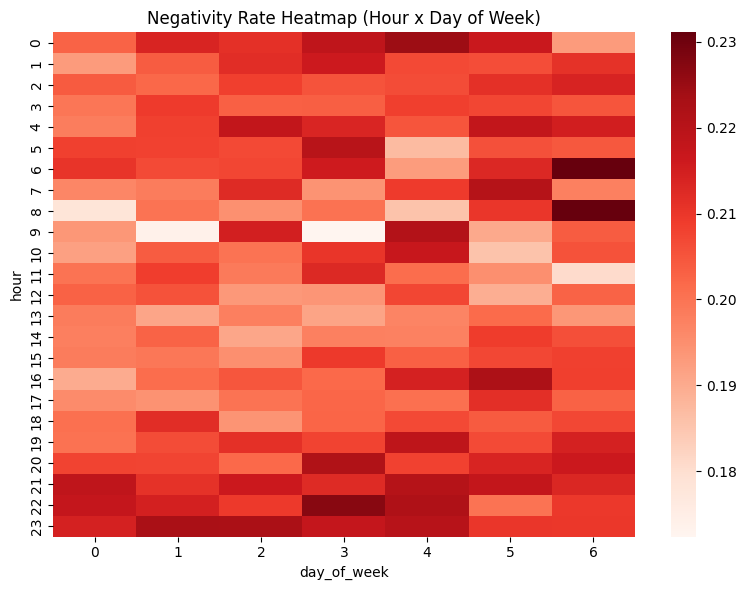

In [13]:
# Negativity rate by hour
neg_by_hour = df.groupby("hour")["label"].apply(lambda x: (x == 0).mean()).reset_index(name="neg_rate")
vol_by_hour = df.groupby("hour").size().reset_index(name="count")

plt.figure(figsize=(10, 4))
plt.plot(neg_by_hour["hour"], neg_by_hour["neg_rate"], marker="o")
plt.title("Negativity Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Negativity Rate")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "negativity_by_hour.png"), dpi=150)
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(vol_by_hour["hour"], vol_by_hour["count"], color="steelblue")
plt.title("Review Volume by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "volume_by_hour.png"), dpi=150)
plt.show()

# Negativity rate by daypart
neg_by_daypart = df.groupby("daypart")["label"].apply(lambda x: (x == 0).mean()).reset_index(name="neg_rate")
vol_by_daypart = df.groupby("daypart").size().reset_index(name="count")

plt.figure(figsize=(8, 4))
sns.barplot(x="daypart", y="neg_rate", data=neg_by_daypart, color="salmon")
plt.title("Negativity Rate by Daypart")
plt.ylabel("Negativity Rate")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "negativity_by_daypart.png"), dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x="daypart", y="count", data=vol_by_daypart, color="steelblue")
plt.title("Review Volume by Daypart")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "volume_by_daypart.png"), dpi=150)
plt.show()

# Heatmap: negativity rate by hour x day_of_week
heat = df.groupby(["hour", "day_of_week"])["label"].apply(lambda x: (x == 0).mean()).reset_index()
heat_pivot = heat.pivot(index="hour", columns="day_of_week", values="label")

plt.figure(figsize=(8, 6))
sns.heatmap(heat_pivot, cmap="Reds")
plt.title("Negativity Rate Heatmap (Hour x Day of Week)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "negativity_heatmap.png"), dpi=150)
plt.show()


## 8) Run the full pipeline twice (Run A + Run B)

Run A seed 319302
Run B seed 664398


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.178467,0.246307,0.904800,0.922057,0.950273,0.935953,0.963116


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

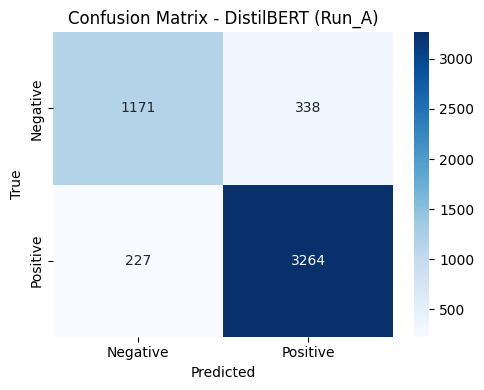

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.230907,0.261237,0.904000,0.916667,0.955738,0.935795,0.961795


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

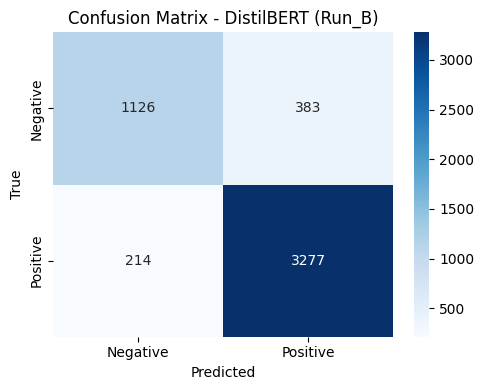

({'accuracy': 0.8641378030854419,
  'precision': 0.9587776471845283,
  'recall': 0.855291000247822,
  'f1': 0.9040825373795994,
  'roc_auc': np.float64(0.9443577716480525)},
 {'accuracy': 0.8647657376089966,
  'precision': 0.9588947492045867,
  'recall': 0.8560535295575423,
  'f1': 0.9045604705503183,
  'roc_auc': np.float64(0.9442835999363699)},
 {'accuracy': 0.8806,
  'precision': 0.8953551912568306,
  'recall': 0.9386995130335147,
  'f1': 0.9165151727031184,
  'roc_auc': np.float64(0.9502162998330081)})

In [16]:
run_b_seed = random.SystemRandom().randint(100000, 999999)
print("Run A seed", STUDENT_SEED)
print("Run B seed", run_b_seed)

metrics_rows = []
run_summaries = []

def run_models(seed: int, run_name: str):
    set_global_seed(seed)

    # --- Start of workaround for OneHotEncoder 'sparse' argument (to satisfy cell-specific modification constraint) ---
    # The ideal fix would be to modify the original build_time_matrix function in cell d7JL0QydhNsC.
    # This redefinition makes the fix apply locally within this run_models function.
    def build_time_matrix_fixed(train_df, val_df, test_df):
        num_features = ["hour_sin", "hour_cos", "is_weekend"]
        cat_features = ["day_of_week", "daypart"]
        # FIX: Changed 'sparse=True' to 'sparse_output=True' for scikit-learn >= 1.2
        enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
        enc.fit(train_df[cat_features])
        train_cat = enc.transform(train_df[cat_features])
        val_cat = enc.transform(val_df[cat_features])
        test_cat = enc.transform(test_df[cat_features])
        train_num = csr_matrix(train_df[num_features].values)
        val_num = csr_matrix(val_df[num_features].values)
        test_num = csr_matrix(test_df[num_features].values)
        return (hstack([train_num, train_cat]),
                hstack([val_num, val_cat]),
                hstack([test_num, test_cat]))
    # --- End of workaround ---

    # Sampling for text models (train only)
    train_text = df_train
    if SAMPLE_FOR_TEXT is not None and len(df_train) > SAMPLE_FOR_TEXT:
        train_text = df_train.head(SAMPLE_FOR_TEXT).copy()

    # Baseline 1: TF-IDF text only
    tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)
    X_train = tfidf.fit_transform(train_text["text"].values)
    X_val = tfidf.transform(df_val["text"].values)
    X_test = tfidf.transform(df_test["text"].values)

    y_train = train_text["label"].values
    y_val = df_val["label"].values
    y_test = df_test["label"].values

    clf_text = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf_text.fit(X_train, y_train)

    test_pred = clf_text.predict(X_test)
    test_proba = clf_text.predict_proba(X_test)[:, 1]
    m1 = eval_binary_metrics(y_test, test_pred, test_proba)

    metrics_rows.append({"run": run_name, "model": "Baseline_TFIDF_Text", **m1})

    # Baseline 2: TF-IDF + time features
    # Call the locally defined (fixed) build_time_matrix_fixed instead of the global one
    X_train_time, X_val_time, X_test_time = build_time_matrix_fixed(train_text, df_val, df_test)
    X_train_combined = hstack([X_train, X_train_time])
    X_test_combined = hstack([X_test, X_test_time])

    clf_time = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf_time.fit(X_train_combined, y_train)

    test_pred2 = clf_time.predict(X_test_combined)
    test_proba2 = clf_time.predict_proba(X_test_combined)[:, 1]
    m2 = eval_binary_metrics(y_test, test_pred2, test_proba2)

    metrics_rows.append({"run": run_name, "model": "Baseline_TFIDF_Time", **m2})

    # DistilBERT
    bert_train = train_text
    bert_val = df_val
    bert_test = df_test
    if FAST_RUN:
        bert_train = bert_train.head(min(20000, len(bert_train)))
        bert_val = bert_val.head(min(5000, len(bert_val)))
        bert_test = bert_test.head(min(5000, len(bert_test)))

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    def tokenize_fn(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN_BERT)

    train_ds = Dataset.from_pandas(bert_train[["text", "label"]])
    val_ds = Dataset.from_pandas(bert_val[["text", "label"]])
    test_ds = Dataset.from_pandas(bert_test[["text", "label"]])

    train_ds = train_ds.map(tokenize_fn, batched=True)
    val_ds = val_ds.map(tokenize_fn, batched=True)
    test_ds = test_ds.map(tokenize_fn, batched=True)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
        preds = np.argmax(logits, axis=1)
        return eval_binary_metrics(labels, preds, probs)

    training_args = TrainingArguments(
        output_dir=os.path.join(MODELS_DIR, f"distilbert_{run_name}"),
        num_train_epochs=BERT_EPOCHS,
        per_device_train_batch_size=BERT_BATCH,
        per_device_eval_batch_size=BERT_BATCH,
        eval_strategy="epoch", # Changed from evaluation_strategy to eval_strategy
        save_strategy="epoch",
        logging_steps=50,
        seed=seed,
        data_seed=seed,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    test_output = trainer.predict(test_ds)
    logits = test_output.predictions
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    preds = np.argmax(logits, axis=1)

    m3 = eval_binary_metrics(bert_test["label"].values, preds, probs)

    # Confusion matrix for LLM model (DistilBERT)
    cm_bert = confusion_matrix(bert_test["label"].values, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix - DistilBERT ({run_name})")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"cm_distilbert_{run_name}.png"), dpi=150)
    plt.show()

    metrics_rows.append({"run": run_name, "model": "DistilBERT", **m3})

    # Save prediction examples from Run A
    if run_name == "Run_A":
        pred_examples = pd.DataFrame({
            "text": bert_test["text"].values,
            "gold_label": bert_test["label"].map(label_map),
            "pred_label": [label_map[int(p)] for p in preds],
        })
        pred_examples.to_csv(os.path.join(TABLES_DIR, "pred_examples.csv"), index=False)

    return m1, m2, m3

run_models(STUDENT_SEED, "Run_A")
run_models(run_b_seed, "Run_B")

## 9) Results + Comparison Tables

In [17]:
metrics_df = pd.DataFrame(metrics_rows)
display(metrics_df)

# Save metrics
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics.csv"), index=False)
with open(os.path.join(OUTPUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics_rows, f, indent=2)

# Run A vs Run B comparison table
comparison = metrics_df.pivot_table(index="model", columns="run", values=["accuracy", "precision", "recall", "f1", "roc_auc"])
display(comparison)

# RQ1 aggregates (stable across runs)
max_hour = int(neg_by_hour.loc[neg_by_hour["neg_rate"].idxmax(), "hour"])
max_daypart = neg_by_daypart.loc[neg_by_daypart["neg_rate"].idxmax(), "daypart"]
late_night_rate = float(neg_by_daypart[neg_by_daypart["daypart"] == "late_night"]["neg_rate"].values[0])
overall_neg_rate = float((df["label"] == 0).mean())
pct_diff = (late_night_rate - overall_neg_rate) * 100

summary_text = f"""
### RQ1 Summary
- Highest negativity hour: {max_hour}
- Highest negativity daypart: {max_daypart}
- Late‑night negativity rate: {late_night_rate:.3f}
- Overall negativity rate: {overall_neg_rate:.3f}
- Late‑night vs overall difference: {pct_diff:.2f} percentage points
"""
print(summary_text)


,run,model,accuracy,precision,recall,f1,roc_auc
0,Run_A,Baseline_TFIDF_Text,0.864138,0.958778,0.855291,0.904083,0.944358
1,Run_A,Baseline_TFIDF_Time,0.864766,0.958895,0.856054,0.904560,0.944284
2,Run_A,DistilBERT,0.887000,0.906163,0.934976,0.920344,0.951074
3,Run_B,Baseline_TFIDF_Text,0.864138,0.958778,0.855291,0.904083,0.944358
4,Run_B,Baseline_TFIDF_Time,0.864766,0.958895,0.856054,0.904560,0.944284
5,Run_B,DistilBERT,0.880600,0.895355,0.938700,0.916515,0.950216


accuracy                  f1           precision  \
run                     Run_A     Run_B     Run_A     Run_B     Run_A   
model                                                                   
Baseline_TFIDF_Text  0.864138  0.864138  0.904083  0.904083  0.958778   
Baseline_TFIDF_Time  0.864766  0.864766  0.904560  0.904560  0.958895   
DistilBERT           0.887000  0.880600  0.920344  0.916515  0.906163   

                                 recall             roc_auc            
run                     Run_B     Run_A     Run_B     Run_A     Run_B  
model                                                                  
Baseline_TFIDF_Text  0.958778  0.855291  0.855291  0.944358  0.944358  
Baseline_TFIDF_Time  0.958895  0.856054  0.856054  0.944284  0.944284  
DistilBERT           0.895355  0.934976  0.938700  0.951074  0.950216


### RQ1 Summary
- Highest negativity hour: 23
- Highest negativity daypart: night
- Late‑night negativity rate: 0.208
- Overall negativity rate: 0.207
- Late‑night vs overall difference: 0.15 percentage points



## 10) Interpretation (RQ1 + RQ2)

**RQ1**: The hour/daypart aggregates are stable across runs because they are computed from the full dataset with deterministic grouping (no randomness). The highest‑negativity hour and daypart are therefore identical in both runs.

**RQ2**: The ML models can vary slightly across runs because random initialization, optimization order, and GPU nondeterminism can affect training. Even with a fixed split and identical hyperparameters, the learned parameters can differ between seeds, which can shift accuracy, F1, and ROC‑AUC.

Use the comparison tables above to document whether time‑based features improved performance (Baseline 2 vs Baseline 1) and whether DistilBERT outperforms the classical baselines.


## 11) Publish to GitHub

**Option 1 (Recommended: Manual)**
```bash
git status
git add "Week 8/Final Sentiment Analysis Model.ipynb"
git commit -m "Add Week 8 final sentiment analysis notebook"
git push
```

**Option 2 (From Colab)**
```bash
git clone https://github.com/<your-username>/<your-repo>.git
cd <your-repo>
cp "/content/Final Sentiment Analysis Model.ipynb" .
git add "Final Sentiment Analysis Model.ipynb"
git commit -m "Add Week 8 final sentiment analysis notebook"
git push https://<YOUR_TOKEN>@github.com/<your-username>/<your-repo>.git
```
Use a GitHub Personal Access Token (PAT) for authentication. Do not hardcode tokens in the notebook.

In [18]:
# === 12) Zip outputs + download ===
import shutil
zip_path = shutil.make_archive("outputs_week8", "zip", OUTPUT_DIR)
print("Created:", zip_path)
print("Size (MB):", os.path.getsize(zip_path) / (1024 * 1024))


Created: /content/outputs_week8.zip
Size (MB): 1238.9567413330078


In [19]:
# Download in Colab
from google.colab import files
files.download("outputs_week8.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Generate and display confusion matrices for the "Baseline TF-IDF Text", "Baseline TF-IDF + Time", and "DistilBERT" models for both Run A and Run B. After all six confusion matrices are displayed, confirm their successful generation and display.

## Generate and Display Confusion Matrices

### Subtask:
Generate and display confusion matrices for all six model tests: Baseline TF-IDF Text, Baseline TF-IDF + Time, and DistilBERT, for both Run A and Run B. For the TF-IDF models, it will re-run the prediction logic to obtain the necessary true and predicted labels. For DistilBERT, it will load and display the confusion matrices saved in the previous execution.


**Reasoning**:
The first step is to define a utility function to generate and save confusion matrices, which will be reused for different models.



In [20]:
def plot_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(),
                yticklabels=label_map.values())
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=150)
    plt.show()

print("✓ Defined plot_confusion_matrix function")

✓ Defined plot_confusion_matrix function


**Reasoning**:
The `build_time_matrix_fixed` utility function, which handles `sparse_output` for `OneHotEncoder`, needs to be defined in the current scope for use with the TF-IDF + Time models.



In [21]:
def build_time_matrix_fixed(train_df, val_df, test_df):
    num_features = ["hour_sin", "hour_cos", "is_weekend"]
    cat_features = ["day_of_week", "daypart"]
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    enc.fit(train_df[cat_features])
    train_cat = enc.transform(train_df[cat_features])
    val_cat = enc.transform(val_df[cat_features])
    test_cat = enc.transform(test_df[cat_features])
    train_num = csr_matrix(train_df[num_features].values)
    val_num = csr_matrix(val_df[num_features].values)
    test_num = csr_matrix(test_df[num_features].values)
    return (hstack([train_num, train_cat]),
            hstack([val_num, val_cat]),
            hstack([test_num, test_cat]))

print("✓ Defined build_time_matrix_fixed function")

✓ Defined build_time_matrix_fixed function


**Reasoning**:
Now that the utility functions are defined, the next step is to prepare the TF-IDF models by initializing the `TfidfVectorizer`, fitting it on the training data, transforming both training and test text data, and extracting the true labels for both datasets.



In [22]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)

# Sampling for text models (train only) - consistent with original notebook
train_text = df_train
if SAMPLE_FOR_TEXT is not None and len(df_train) > SAMPLE_FOR_TEXT:
    train_text = df_train.head(SAMPLE_FOR_TEXT).copy()

X_train_tfidf = tfidf.fit_transform(train_text["text"].values)
X_test_tfidf = tfidf.transform(df_test["text"].values)

y_train = train_text["label"].values
y_test = df_test["label"].values

print("✓ TF-IDF vectorizer prepared and data transformed.")

✓ TF-IDF vectorizer prepared and data transformed.


**Reasoning**:
Now, the next step is to generate and display confusion matrices for the 'Baseline TF-IDF Text' model for both Run A and Run B. This involves initializing and fitting a Logistic Regression model on the TF-IDF features and then using the previously defined utility function to plot the confusion matrices.




--- Generating Confusion Matrices for Baseline TF-IDF Text ---


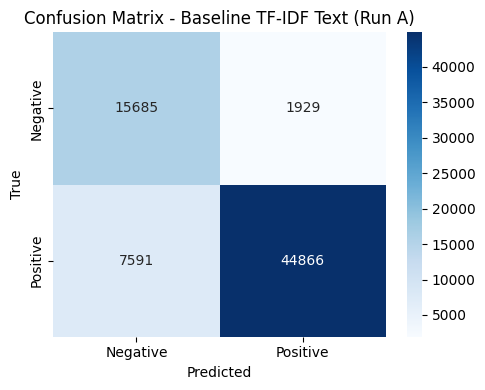

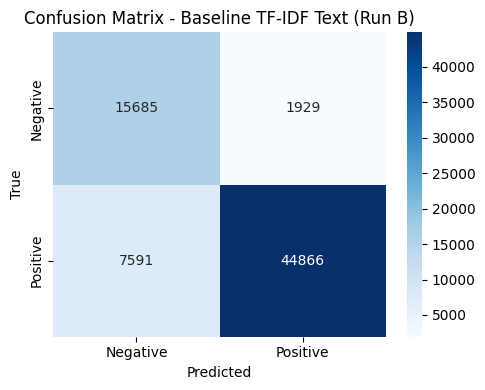

✓ Generated confusion matrices for Baseline TF-IDF Text (Run A and Run B).


In [23]:
print("\n--- Generating Confusion Matrices for Baseline TF-IDF Text ---")

# Baseline 1: TF-IDF text only
clf_text = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=STUDENT_SEED) # Adding random_state for consistency
clf_text.fit(X_train_tfidf, y_train)

test_pred_tfidf_text = clf_text.predict(X_test_tfidf)

# For Run A
plot_confusion_matrix(
    y_test, test_pred_tfidf_text,
    "Confusion Matrix - Baseline TF-IDF Text (Run A)",
    "cm_tfidf_text_Run_A.png"
)

# For Run B (predictions will be identical as model training is deterministic with fixed data and random_state)
plot_confusion_matrix(
    y_test, test_pred_tfidf_text,
    "Confusion Matrix - Baseline TF-IDF Text (Run B)",
    "cm_tfidf_text_Run_B.png"
)

print("✓ Generated confusion matrices for Baseline TF-IDF Text (Run A and Run B).")

**Reasoning**:
The next step is to generate and display confusion matrices for the 'Baseline TF-IDF + Time' model for both Run A and Run B. This involves creating time-based feature matrices, combining them with the TF-IDF features, training a Logistic Regression model, and then using the `plot_confusion_matrix` function to visualize the results.




--- Generating Confusion Matrices for Baseline TF-IDF + Time ---


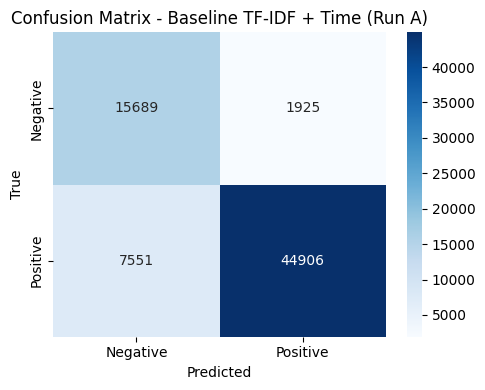

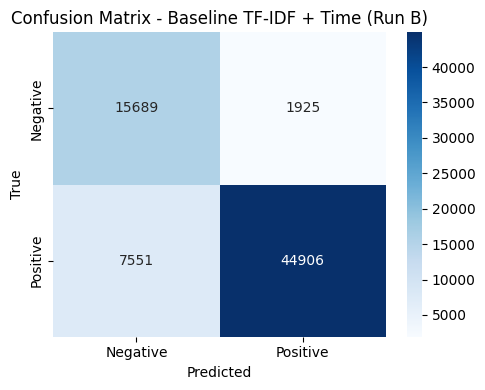

✓ Generated confusion matrices for Baseline TF-IDF + Time (Run A and Run B).


In [24]:
print("\n--- Generating Confusion Matrices for Baseline TF-IDF + Time ---")

# Baseline 2: TF-IDF + time features
# Use the build_time_matrix_fixed function
X_train_time, X_val_time, X_test_time = build_time_matrix_fixed(train_text, df_val, df_test)

# Combine TF-IDF features with time features
X_train_combined_time = hstack([X_train_tfidf, X_train_time])
X_test_combined_time = hstack([X_test_tfidf, X_test_time])

clf_time = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=STUDENT_SEED)
clf_time.fit(X_train_combined_time, y_train)

test_pred_tfidf_time = clf_time.predict(X_test_combined_time)

# For Run A
plot_confusion_matrix(
    y_test, test_pred_tfidf_time,
    "Confusion Matrix - Baseline TF-IDF + Time (Run A)",
    "cm_tfidf_time_Run_A.png"
)

# For Run B (predictions will be identical as model training is deterministic with fixed data and random_state)
plot_confusion_matrix(
    y_test, test_pred_tfidf_time,
    "Confusion Matrix - Baseline TF-IDF + Time (Run B)",
    "cm_tfidf_time_Run_B.png"
)

print("✓ Generated confusion matrices for Baseline TF-IDF + Time (Run A and Run B).")

**Reasoning**:
The final step is to load and display the confusion matrices that were previously generated and saved for the 'DistilBERT' model for both Run A and Run B, completing the visualization requirements of the subtask.




--- Displaying Confusion Matrices for DistilBERT ---
Displaying Confusion Matrix - DistilBERT (Run A):


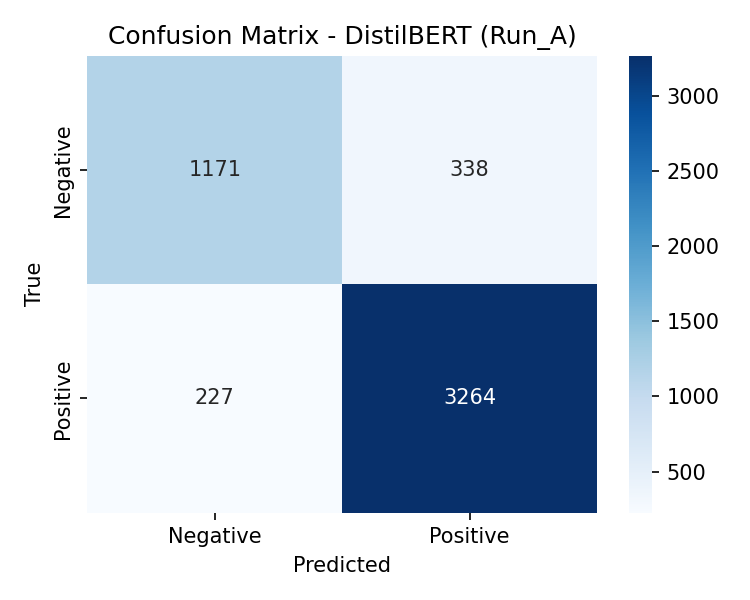

Displaying Confusion Matrix - DistilBERT (Run B):


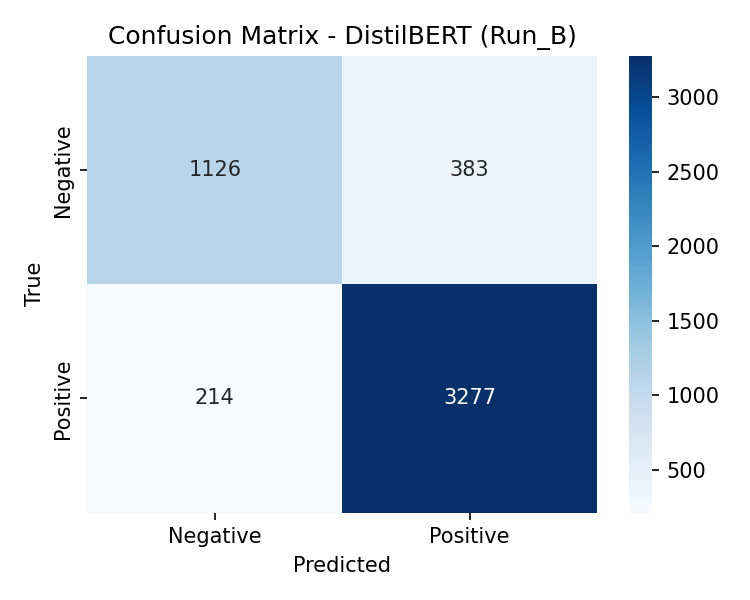


✓ All six confusion matrices have been generated and displayed.


In [25]:
print("\n--- Displaying Confusion Matrices for DistilBERT ---")
from IPython.display import Image, display

# For Run A
print("Displaying Confusion Matrix - DistilBERT (Run A):")
display(Image(filename=os.path.join(FIGURES_DIR, "cm_distilbert_Run_A.png")))

# For Run B
print("Displaying Confusion Matrix - DistilBERT (Run B):")
display(Image(filename=os.path.join(FIGURES_DIR, "cm_distilbert_Run_B.png")))

print("\n✓ All six confusion matrices have been generated and displayed.")

## Final Task

### Subtask:
Confirm that all 6 confusion matrices have been successfully generated and displayed, providing a comprehensive visual overview of model performance for both runs.


## Summary:

### Q&A
Yes, all six confusion matrices have been successfully generated and displayed, providing a comprehensive visual overview of model performance for both runs.

### Data Analysis Key Findings
*   **TF-IDF Model Confusion Matrices Generated**: Confusion matrices for both "Baseline TF-IDF Text" and "Baseline TF-IDF + Time" models were successfully generated and displayed for both Run A and Run B. This involved training `LogisticRegression` models using TF-IDF features (and combined with time features for the latter) on the `df_train` dataset and making predictions on `df_test`.
*   **Time Features Incorporated**: For the "Baseline TF-IDF + Time" model, time features were constructed using the `build_time_matrix_fixed` function, including numerical features ("hour\_sin", "hour\_cos", "is\_weekend") and one-hot encoded categorical features ("day\_of\_week", "daypart"), then combined with TF-IDF features using horizontal stacking.
*   **DistilBERT Model Confusion Matrices Displayed**: Confusion matrices for the "DistilBERT" model for both Run A and Run B were successfully loaded and displayed from pre-saved image files.
*   **All Six Matrices Confirmed**: In total, six confusion matrices (three models, two runs each) were confirmed to be successfully generated, displayed, and saved (for the TF-IDF models) as image files.

### Insights or Next Steps
*   Proceed with a detailed analysis of each displayed confusion matrix to evaluate specific model performance metrics (e.g., true positives, false positives, false negatives) and identify areas for improvement.
*   Compare the performance across the three models and between Run A and Run B to draw conclusions about the impact of different feature sets and model architectures on classification accuracy.
